# Create star formation history figure

In [1]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d, interp2d
from scipy.stats import maxwell, norm, uniform, powerlaw, truncnorm
from scipy import optimize
import corner
from astropy.coordinates import SkyCoord

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Load the LMC star formation history

In [3]:
# radian to dec and vice-versa functions

def dec_to_rad(theta):
    return np.pi * theta / 180.0
def rad_to_dec(theta):
    return 180.0 * theta / np.pi

In [4]:
# Create an empty array to start with
dtypes = [('region','<S10'), \
          ('log_age','<f8'), \
          ('sfh_z008','<f8'), \
          ('sfh_z004','<f8'), \
          ('sfh_z0025','<f8'), \
          ('sfh_z001','<f8')]
lmc_sfh = np.recarray(0, dtype=dtypes)
out_line = np.recarray(1, dtype=dtypes)


with open("../data/lmc_data/lmc_sfh_reduced.dat") as f:
    line_num = 0

    for line in f:
        line_num += 1

        if line_num < 17: continue
        if "Region" in line: 
            region = np.array(line.split()[2]).astype(np.str)
        elif "(" in line:
            1 == 1
        else:
            line_data = line.split()
            line_data = np.array(line_data).astype(np.float64)
                                    
            out_line[0][0] = region
            out_line[0][1] = line_data[0]
            out_line[0][2] = line_data[1]
            out_line[0][3] = line_data[4]
            out_line[0][4] = line_data[7]
            out_line[0][5] = line_data[10]

            lmc_sfh = np.append(lmc_sfh, out_line[0])

In [7]:
# Load region coordinates
data_file = os.path.abspath("../data/lmc_data/lmc_coordinates.dat")
lmc_coor_2 = np.genfromtxt(data_file, dtype="S10,S2,S2,S3,S2")

lmc_coor = np.recarray(0, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])
tmp = np.recarray(1, dtype=[('region','<S10'),('ra','float64'),('dec','float64')])


for coor in lmc_coor_2:
    ra = str(coor[1])+"h"+str(coor[2])+"m"
    dec = str(coor[3])+"d"+str(coor[4])+"m"

    region = coor[0]
    
    coor = SkyCoord(ra, dec)
    
    tmp["region"] = region
    tmp["ra"] = coor.ra.degree
    tmp["dec"] = coor.dec.degree

    lmc_coor = np.append(lmc_coor, tmp)

In [8]:
def get_theta_proj_decimal(ra, dec, ra_b, dec_b):
    
    ra1 = dec_to_rad(ra) 
    dec1 = dec_to_rad(dec)
    ra2 = dec_to_rad(ra_b)
    dec2 = dec_to_rad(dec_b)
    return np.sqrt((ra1-ra2)**2 * np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)

def get_new_ra_dec(ra, dec, theta_proj, pos_ang):
    delta_dec = theta_proj * np.cos(pos_ang)
    delta_ra = theta_proj * np.sin(pos_ang) / np.cos(dec_to_rad(dec))
    
    ra_out = ra + rad_to_dec(delta_ra)
    dec_out = dec + rad_to_dec(delta_dec)

    return ra_out, dec_out
    

regions = np.unique(lmc_sfh["region"])

SF_history = np.array([])
age = np.array([])
sfr = np.array([])
for r in regions:
    
    age = lmc_sfh["log_age"][np.where(lmc_sfh["region"] == r)]
    sfr = lmc_sfh["sfh_z008"][np.where(lmc_sfh["region"] == r)]        
    
    SF_history = np.append(SF_history, interp1d(age[::-1], sfr[::-1], bounds_error=False, fill_value=0.0))
    

def get_SFH(ra, dec, t_b):
    """ Returns the star formation rate in Msun/Myr for a sky position and age. """
    
    if isinstance(ra, np.ndarray):

        ra1, ra2 = np.meshgrid(dec_to_rad(ra), dec_to_rad(lmc_coor["ra"]))
        dec1, dec2 = np.meshgrid(dec_to_rad(dec), dec_to_rad(lmc_coor["dec"]))
        
        dist = np.sqrt((ra1-ra2)**2*np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
        indices = dist.argmin(axis=0)

        SFR = np.zeros(len(ra))
        for i in np.arange(len(indices)):
            SFR[i] = SF_history[indices[i]](np.log10(t_b[i]*1.0e6))
            
        return SFR
        
    else:
        ra1 = dec_to_rad(ra)
        dec1 = dec_to_rad(dec)
        ra2 = dec_to_rad(lmc_coor["ra"])
        dec2 = dec_to_rad(lmc_coor["dec"])

        dist = np.sqrt((ra1-ra2)**2*np.cos(dec1)*np.cos(dec2) + (dec1-dec2)**2)
        index = np.argmin(dist)
    
        SFH_out = SF_history[index](np.log10(t_b*1.0e6))
        if dist[index] > 0.25: SFH_out = 0.0 # If distance is greater than 0.5 degree, return 0
            
        return rad_to_dec(dist[index]), SFH_out

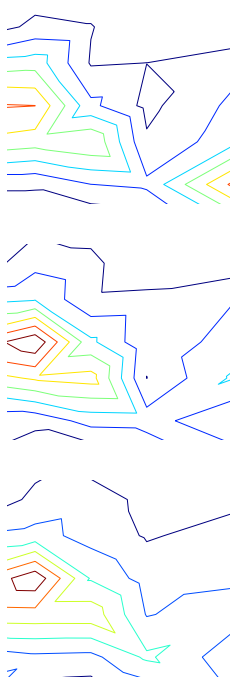

In [23]:

plt.figure(figsize=(4,12))

def get_LMC_plot(age):
    sfr = np.array([])
    for i in np.arange(len(lmc_coor)):
        sfr = np.append(sfr, get_SFH(lmc_coor["ra"][i], lmc_coor["dec"][i], age)[1])

    plt.tricontour(lmc_coor["ra"], lmc_coor["dec"], sfr)
#    plt.title(str(int(age)) + ' Myr')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(82, 84)
    plt.ylim(-69.5, -68.5)
    plt.axis('off')

    return plt
    

    
plt.subplot(3,1,1)
get_LMC_plot(10.0)

plt.subplot(3,1,2)
get_LMC_plot(15.0)

plt.subplot(3,1,3)
get_LMC_plot(20.0)

plt.savefig("../figures/LMC_sample_SFH.pdf")

#plt.show()

# Area = 64 deg^2


